In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mne.decoding import CSP
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import torch
from dataset import EEGDataset
import filter as filter
from mlp import MLP
from plot import plot_eeg, plot_scatter_trials
from model import train_test_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import numpy as np
from sklearn.decomposition import FastICA
import xgboost as xgb
from sklearn.model_selection import train_test_split
import clustering as cl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Hyper parameters
apply_pca = False   
feature_extraction_method = 'CSP'   # 'ICA' or 'CSP'
apply_normalization = False

# Read Dataset

In [6]:
file_path_1 = "../BCICIV_1_mat/BCICIV_calib_ds1a"
data = EEGDataset(file_path_1, start_window=0.5, end_window=3)

# Preprocessing

## Filters

In [7]:
laplacin_filtered = filter.large_laplacian_filter(data)
bandpass_filterd = filter.bandpass_filter(laplacin_filtered,  l_freq=8, h_freq=40)

Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.0s
[Parallel(n_job

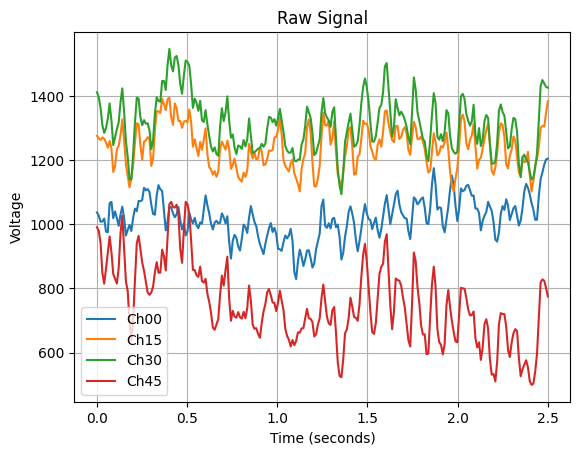

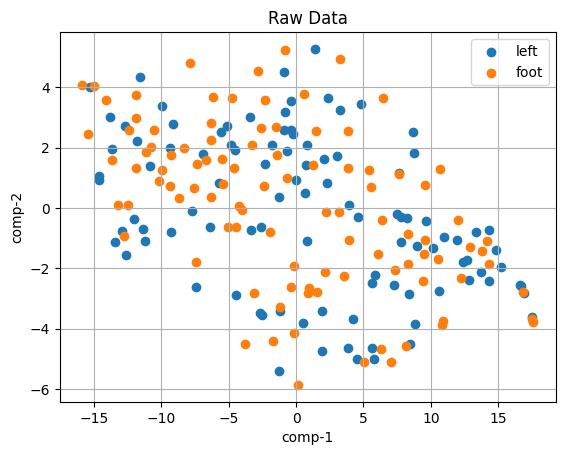

In [8]:
plot_eeg(data, 0, 'Raw Signal')
plt.savefig('../assets/preprocess_raw.png')
plt.show()
plot_scatter_trials(data.trials, data.targets, data.class_labels, 'Raw Data')
plt.savefig('../assets/visual_raw_data.png')

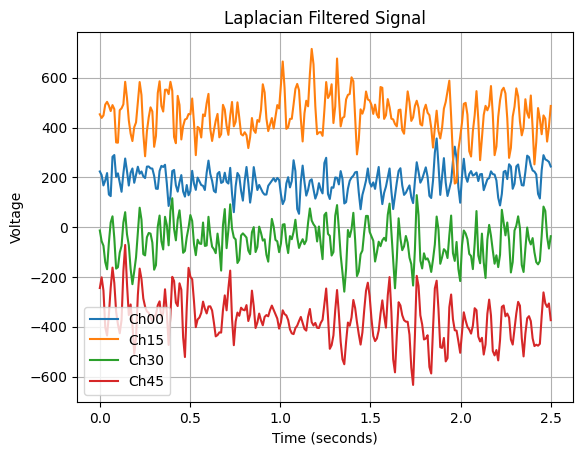

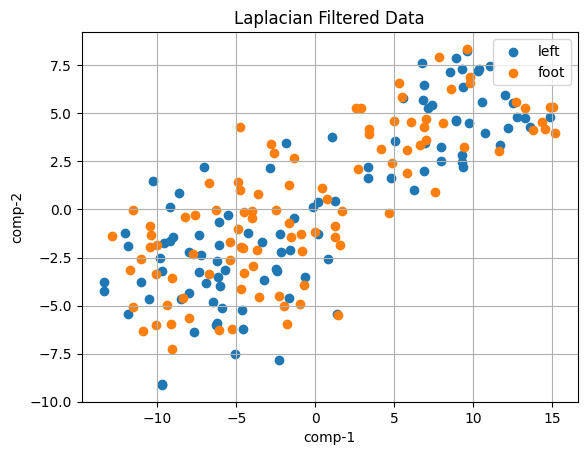

In [9]:
plot_eeg(laplacin_filtered, 0, 'Laplacian Filtered Signal')
plt.savefig('../assets/preprocess_laplacian.png')
plt.show()
plot_scatter_trials(laplacin_filtered.trials, laplacin_filtered.targets, laplacin_filtered.class_labels, 'Laplacian Filtered Data')
plt.savefig('../assets/visual_laplacian_data.png')

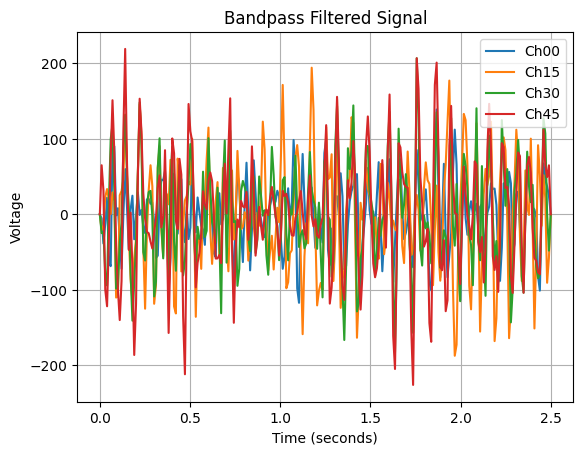

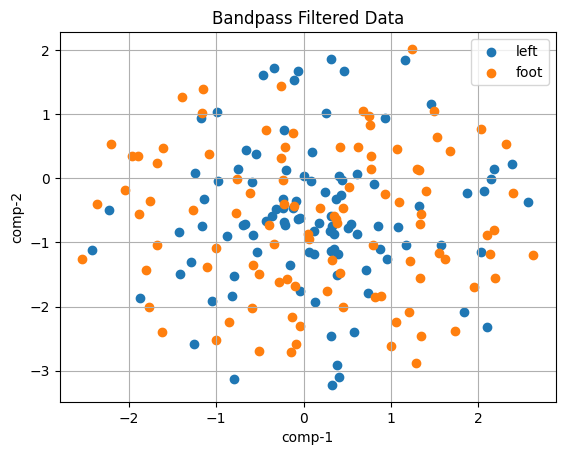

In [10]:
plot_eeg(bandpass_filterd, 0, 'Bandpass Filtered Signal')
plt.savefig('../assets/preprocess_bandpass.png')
plt.show()
plot_scatter_trials(bandpass_filterd.trials, bandpass_filterd.targets, bandpass_filterd.class_labels, 'Bandpass Filtered Data')
plt.savefig('../assets/visual_bandpass_data.png')

In [11]:
data = bandpass_filterd

## Train Test Split

In [12]:
X = data.trials
y = data.targets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=40,
    stratify=y
)

## PCA

In [13]:
pca = PCA(n_components=X_train.shape[0])
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

In [14]:
if apply_pca:
    X_train = X_train_pca.reshape(X_train.shape[0], X_train.shape[0] // 2, 2)
    X_test = X_test_pca.reshape(X_test.shape[0], X_train.shape[0] // 2, 2)

## ICA

In [15]:
ica = FastICA(n_components=59,
              random_state=42)

X_train_ica = ica.fit_transform(X_train.reshape(X_train.shape[0], -1), y_train)

X_test_ica = ica.transform(X_test.reshape(X_test.shape[0], -1))


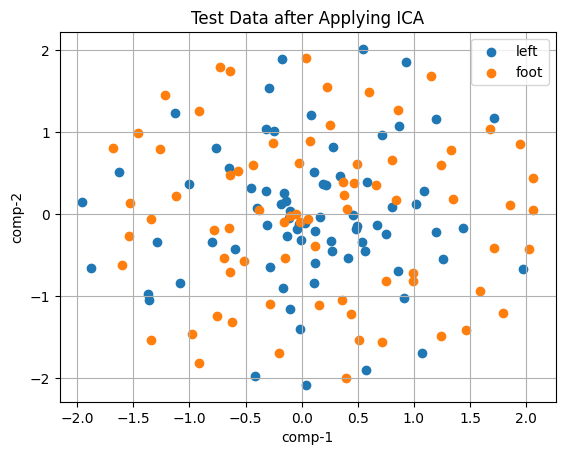

In [16]:
plot_scatter_trials(X_train_ica, y_train, data.class_labels, 'Test Data after Applying ICA')
plt.savefig('../assets/train_data_ica.png') 

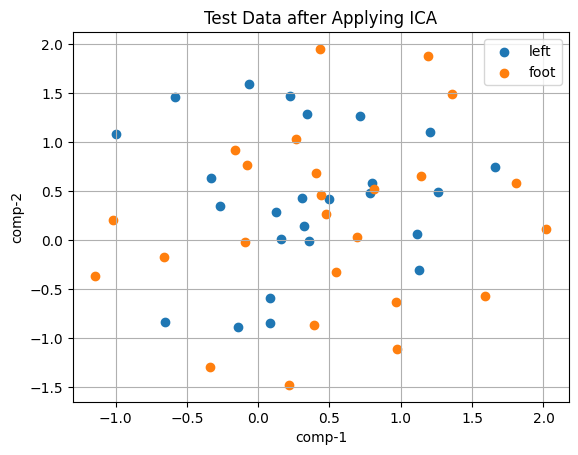

In [17]:
plot_scatter_trials(X_test_ica, y_test, data.class_labels, 'Test Data after Applying ICA')
plt.savefig('../assets/test_data_ica.png') 

## CSP

In [18]:
csp = CSP(n_components=59, reg=None, log=None, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 1.5e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


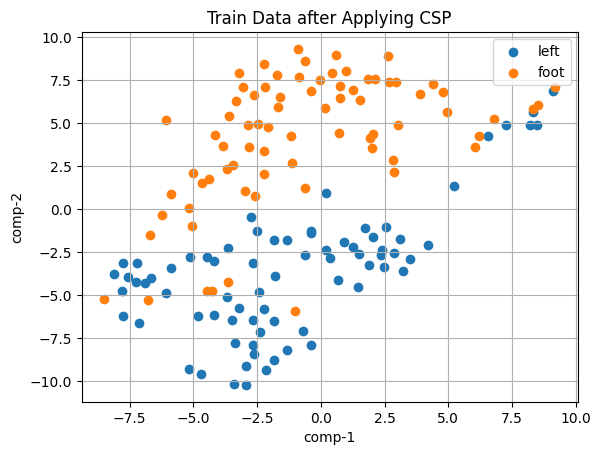

In [19]:
plot_scatter_trials(X_train_csp, y_train, data.class_labels, 'Train Data after Applying CSP')
plt.savefig('../assets/train_data_csp.png')

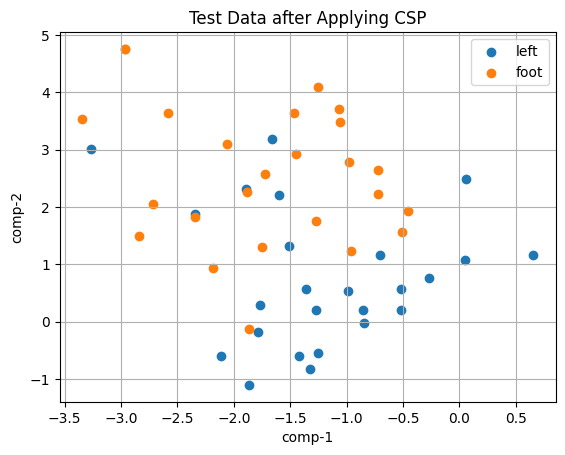

In [20]:
plot_scatter_trials(X_test_csp, y_test, data.class_labels, 'Test Data after Applying CSP')
plt.savefig('../assets/test_data_csp.png') 

In [21]:
if feature_extraction_method == 'ICA':
    X_train = X_train_ica
    X_test = X_test_ica
else:
    X_train = X_train_csp
    X_test = X_test_csp

In [22]:
def normalize(X):
    X_mean = np.mean(X, axis=0)
    X_std_dev = np.std(X, axis=0)
    X_normalized = (X - X_mean) / X_std_dev
    return X_normalized

if apply_normalization:
    X_train = normalize(X_train)
    X_test = normalize(X_test)  

## Logistic Regression

              precision    recall  f1-score   support

        left       0.89      0.96      0.92        25
        foot       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



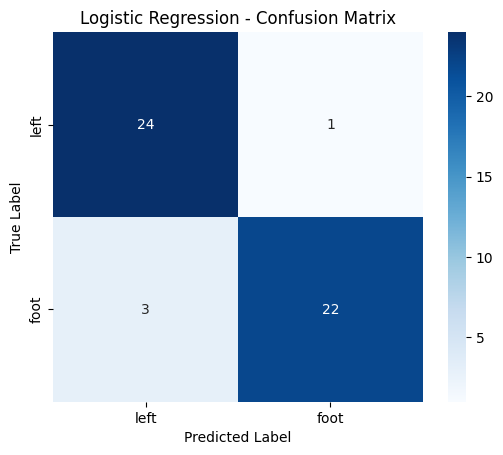

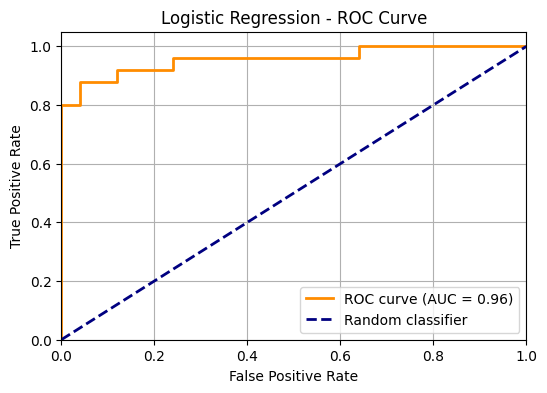

In [23]:
model = LogisticRegression(max_iter=300)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'Logistic Regression')

## SVM

              precision    recall  f1-score   support

        left       0.89      0.96      0.92        25
        foot       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



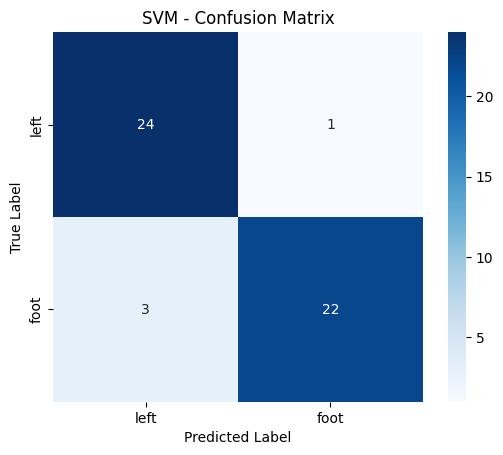

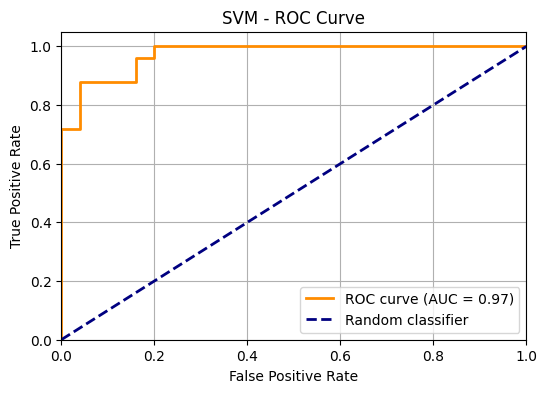

In [24]:
model = SVC(kernel='rbf', C=1, probability=True)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'SVM')

## KNN

              precision    recall  f1-score   support

        left       0.79      0.92      0.85        25
        foot       0.90      0.76      0.83        25

    accuracy                           0.84        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50



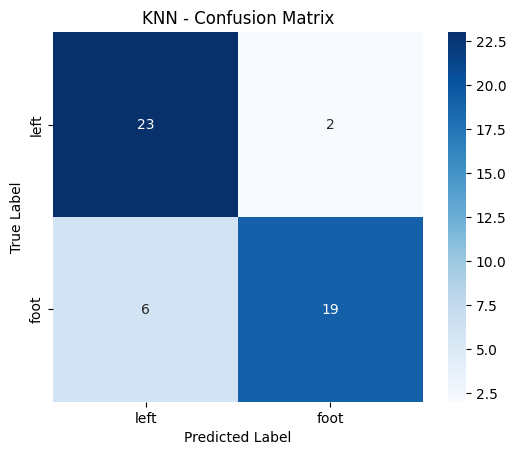

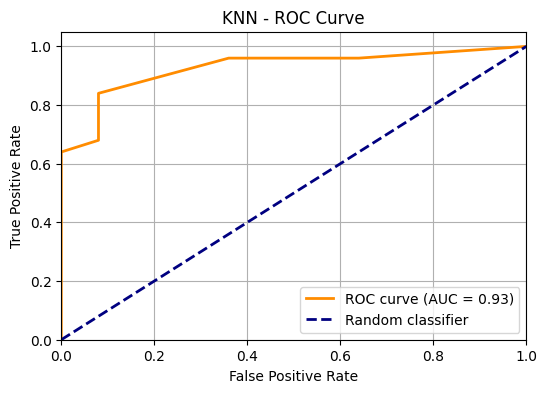

In [25]:
model = KNeighborsClassifier(n_neighbors=7)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'KNN')

## MLP

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(input_shape=(-1, 59),
            num_classes=2, 
            batch_size=64,
            lr=0.001,
            num_epochs=400, 
            device=device
        ).to(device)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'MLP')

## AdaBoost

C:\Users\javadpsk\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

        left       0.89      0.96      0.92        25
        foot       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



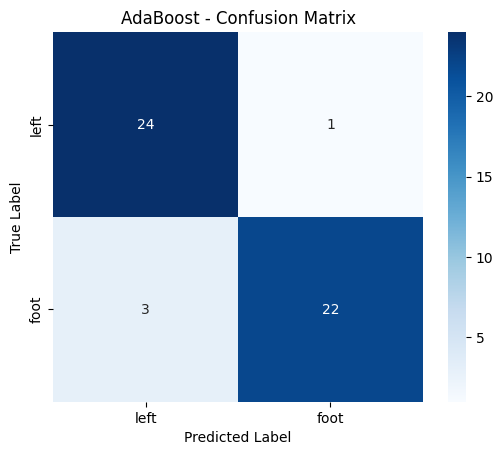

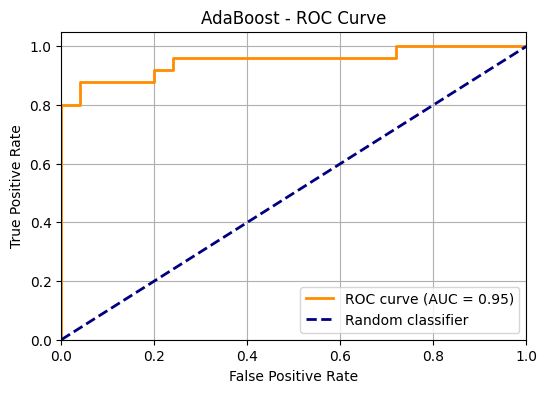

In [27]:
estimator = LogisticRegression(max_iter=300, C=10)
model = AdaBoostClassifier(
    estimator=estimator, 
    n_estimators=10, 
    random_state=42)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'AdaBoost')

## XGBoost

              precision    recall  f1-score   support

        left       0.89      1.00      0.94        25
        foot       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50



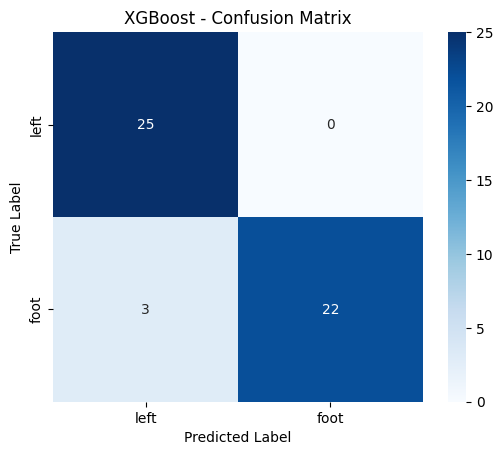

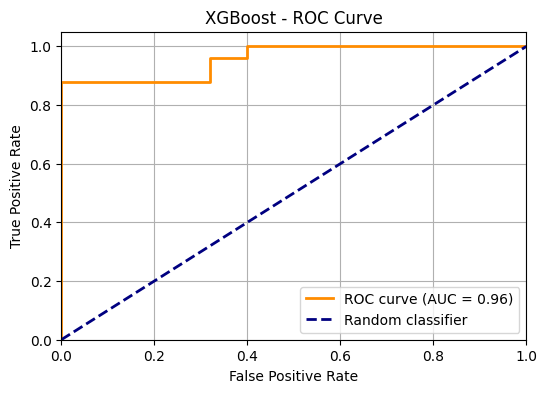

In [28]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=2,
    max_depth=1,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    reg_alpha=2,  
)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'XGBoost')

# Clustering

In [29]:
clustering_X = np.concatenate([X_train_csp, X_test_csp])
Y = np.concatenate([y_train, y_test])
pca = PCA(n_components=2)
X = pca.fit_transform(clustering_X)
scalar = MinMaxScaler()
X = scalar.fit_transform(X)

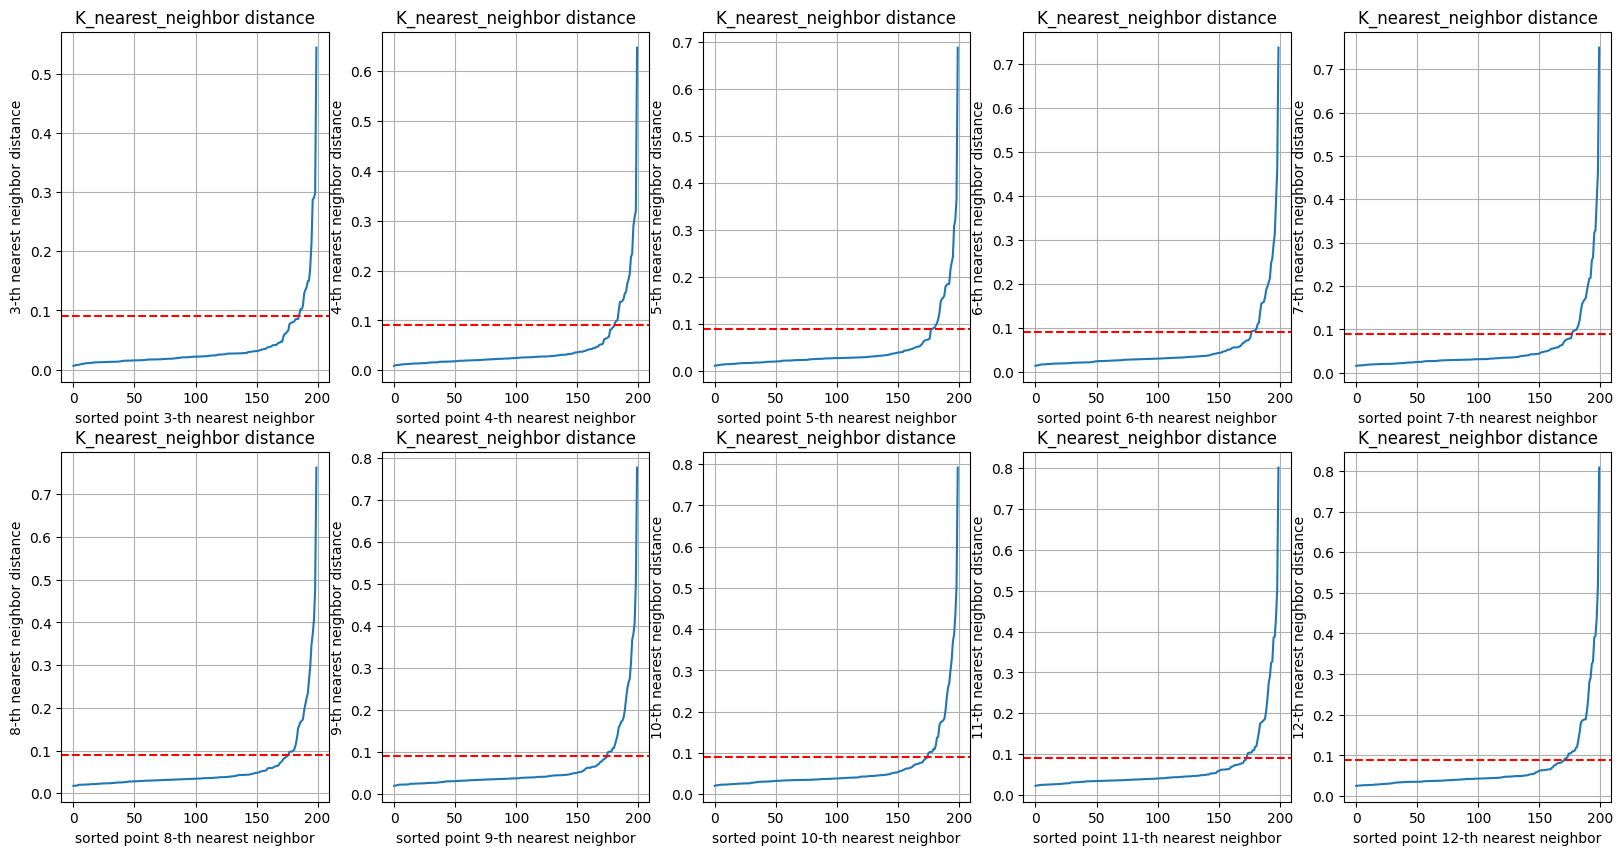

In [30]:
plt.figure(figsize=(20, 10))
for i, k in enumerate(range(3, 13)):
    plt.subplot(2, 5, i+1)
    cl.plot_K_nearest_neighbor_distance(X=X, K=k)

plt.show()

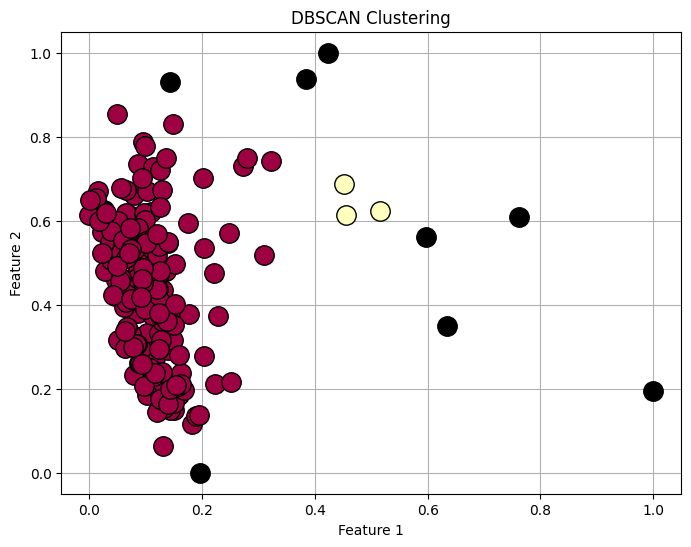

silhouette_score:  0.484871468017328
homogeneity_score:  0.001244645845957331


In [31]:
cl.apply_DB_scan_clustering(eps=0.09, min_samples=3, X=X, y=Y)

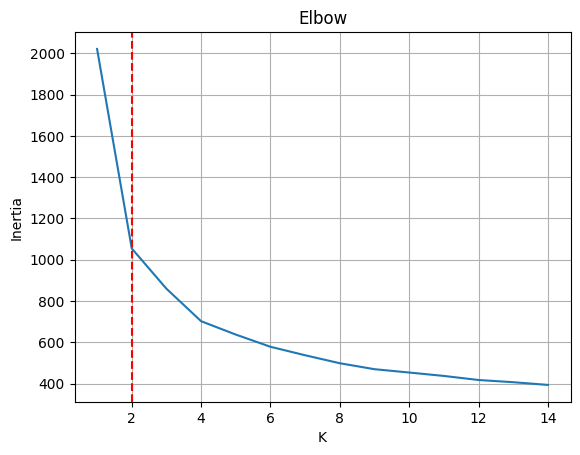

In [32]:
cl.plot_kmeans_elbow(X=clustering_X)

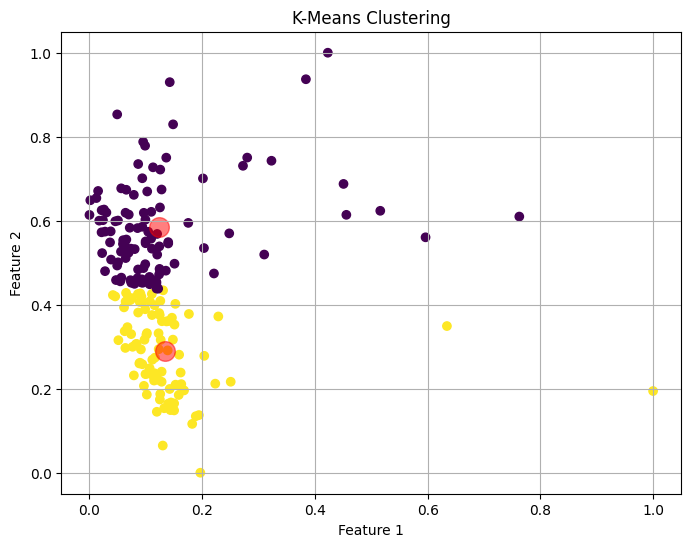

silhouette_score :  0.45120344880569374
homogeneity_score :  0.27954354742236204


In [33]:
cl.apply_kmeans_clustering(X=X, y=Y, k=2)

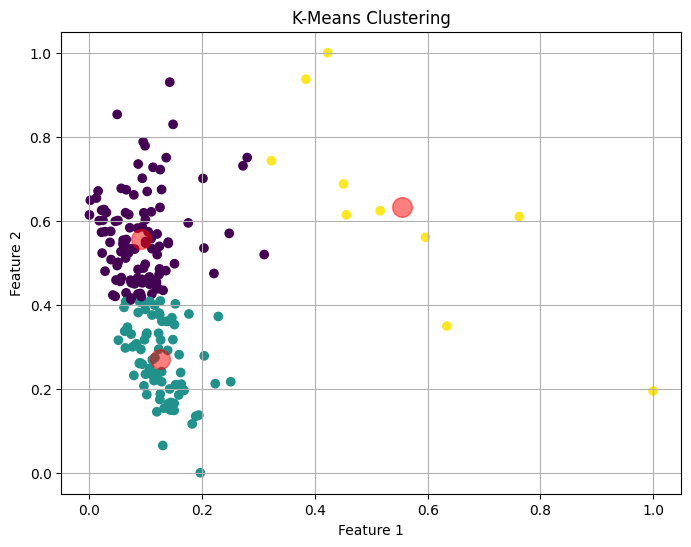

silhouette_score :  0.4932351482431839
homogeneity_score :  0.330777116703999


In [35]:
cl.apply_kmeans_clustering(X=X, y=Y, k=3)

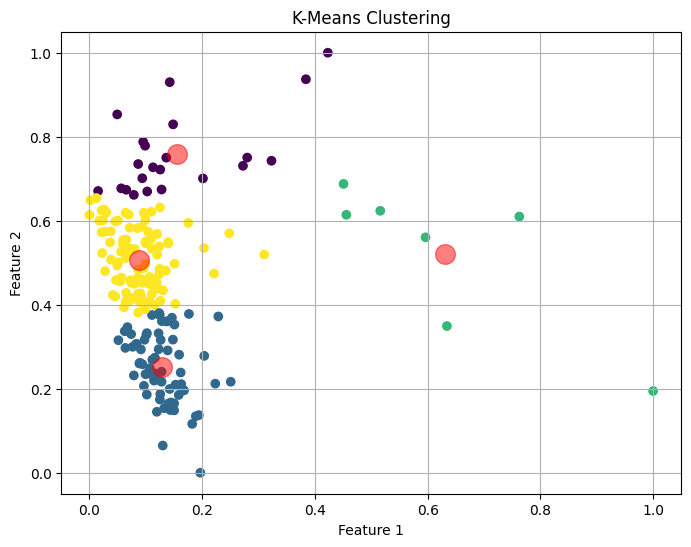

silhouette_score :  0.48278159699272005
homogeneity_score :  0.3878578742814764


In [36]:
cl.apply_kmeans_clustering(X=X, y=Y, k=4)

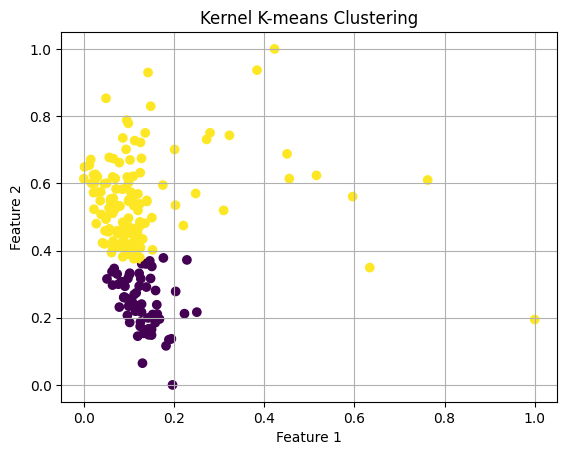

silhouette_score :  0.4474298208909018
omogeneity_score :  0.3514159678195453


In [34]:
cl.apply_kernel_kmeans_clustering(X=X, y=Y, k=2)

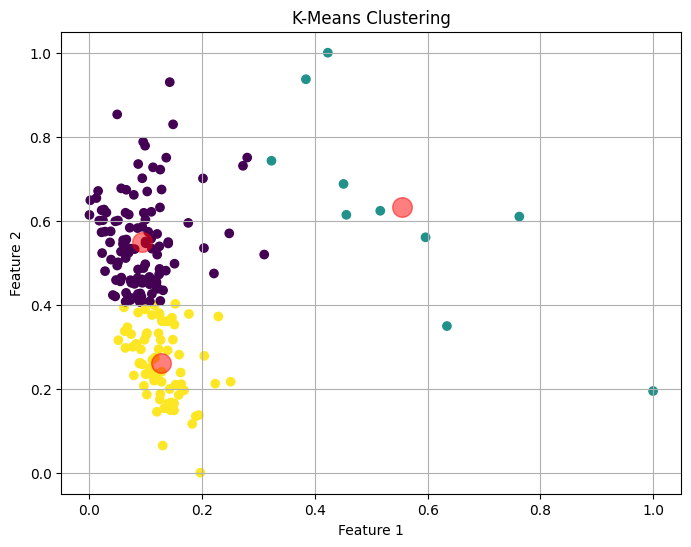

silhouette_score :  0.5003916266405882
homogeneity_score :  0.3557845645195212


In [37]:
cl.apply_kmeans_clustering(X=X, y=Y, k=3)

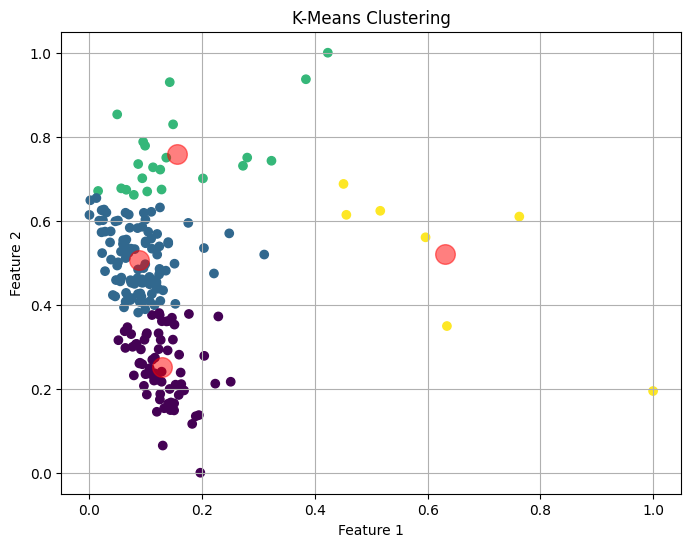

silhouette_score :  0.48278159699272005
homogeneity_score :  0.3878578742814764


In [38]:
cl.apply_kmeans_clustering(X=X, y=Y, k=4)